In [9]:
# Setup: Add project root to Python path
import sys
from pathlib import Path

# Try multiple strategies to find the project root
notebook_dir = Path().resolve()
project_root = None

# Strategy 1: If we're in notebooks/, parent is project root
if notebook_dir.name == 'notebooks' and (notebook_dir.parent / 'src').exists():
    project_root = notebook_dir.parent
# Strategy 2: Check if current directory is project root
elif (notebook_dir / 'src').exists():
    project_root = notebook_dir
# Strategy 3: Check parent directory
elif (notebook_dir.parent / 'src').exists():
    project_root = notebook_dir.parent
# Strategy 4: Walk up directory tree to find src
else:
    current = notebook_dir
    while current != current.parent:
        if (current / 'src').exists():
            project_root = current
            break
        current = current.parent

if project_root:
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    print(f"✓ Project root found: {project_root}")
else:
    print("⚠ Warning: Could not find project root. Trying default path...")
    # Fallback: assume parent if in notebooks/
    if notebook_dir.name == 'notebooks':
        fallback = notebook_dir.parent
    else:
        fallback = notebook_dir
    if str(fallback) not in sys.path:
        sys.path.insert(0, str(fallback))
    print(f"✓ Using fallback path: {fallback}")


✓ Project root found: D:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\plant-species-classification


In [10]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Note: Project root is already added to sys.path by the setup cell above
# No need to add it again here

# PyTorch
import torch
from torch.utils.data import DataLoader

# Dataset and transforms
from src.data.dataset import FlowerDataset
from src.data.augmentation import (
    get_train_transforms,
    get_val_transforms,
    AlbumentationsTransform,
    denormalize,
    tensor_to_image,
    IMAGENET_MEAN,
    IMAGENET_STD
)

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully")
print(f"✓ PyTorch version: {torch.__version__}")


✓ Libraries imported successfully
✓ PyTorch version: 2.5.1+cu121


## 2. Dataset Configuration

Define the paths and parameters used for preprocessing. These match the configuration used during model training.


In [11]:
# Dataset configuration (matching training setup)
# Get project root (parent of notebooks/ directory)
notebook_dir = Path().resolve()
if notebook_dir.name == 'notebooks':
    PROJECT_ROOT = notebook_dir.parent
else:
    PROJECT_ROOT = notebook_dir

DATA_DIR = PROJECT_ROOT / 'data/raw/oxford_flowers_102'
IMAGE_SIZE = 224  # Used for Baseline CNN and ResNet50
BATCH_SIZE = 32
NUM_WORKERS = 4

# Create output directories for saving figures
OUTPUT_DIR = PROJECT_ROOT / 'results/figures'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory created: {OUTPUT_DIR.absolute()}")

# Check if data directory exists
if not DATA_DIR.exists():
    print(f"⚠ Warning: Data directory not found at {DATA_DIR.absolute()}")
    print("Please ensure the Oxford 102 Flower Dataset is downloaded and extracted.")
    DATA_DIR = None
else:
    print(f"✓ Data directory found: {DATA_DIR.absolute()}")
    
print(f"\nConfiguration:")
print(f"  Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Num Workers: {NUM_WORKERS}")
print(f"  ImageNet Normalization:")
print(f"    Mean: {IMAGENET_MEAN}")
print(f"    Std:  {IMAGENET_STD}")


✓ Output directory created: D:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\plant-species-classification\results\figures
✓ Data directory found: D:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\plant-species-classification\data\raw\oxford_flowers_102

Configuration:
  Image Size: 224x224
  Batch Size: 32
  Num Workers: 4
  ImageNet Normalization:
    Mean: [0.485, 0.456, 0.406]
    Std:  [0.229, 0.224, 0.225]


## 3. Training Transforms (with Augmentation)

The training transforms include aggressive data augmentation to improve model generalization:

### Augmentation Techniques:
- **Random Resized Crop**: Scale (0.7-1.0), Aspect Ratio (0.8-1.2)
- **Affine Transformations**: Translation (±10%), Scaling (±10%), Rotation (±30°)
- **Horizontal Flip**: 50% probability
- **Vertical Flip**: 30% probability
- **Color Jittering**: Brightness, contrast, saturation (±30%), hue (±10%)
- **Random Brightness/Contrast**: Additional 20% variation
- **Grayscale Conversion**: 10% probability
- **Gaussian Blur**: 10% probability
- **Normalization**: ImageNet statistics
- **ToTensor**: Convert to PyTorch tensor


In [12]:
# Create training transforms with augmentation (using Albumentations)
train_transform = get_train_transforms(
    image_size=IMAGE_SIZE,
    use_albumentations=True
)

# Wrap for PyTorch Dataset compatibility
train_transform_wrapper = AlbumentationsTransform(train_transform)

print("✓ Training transforms created (with augmentation)")
print(f"  Transform type: Albumentations Compose")
print(f"  Output size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Normalization: ImageNet statistics")


✓ Training transforms created (with augmentation)
  Transform type: Albumentations Compose
  Output size: 224x224
  Normalization: ImageNet statistics


## 4. Validation/Test Transforms (without Augmentation)

Validation and test transforms apply minimal preprocessing:
- **Resize**: Resize to (image_size + 32) for center crop margin
- **Center Crop**: Crop to target image size
- **Normalization**: ImageNet statistics
- **ToTensor**: Convert to PyTorch tensor

No augmentation is applied to ensure consistent evaluation.


In [13]:
# Create validation/test transforms (no augmentation)
val_transform = get_val_transforms(
    image_size=IMAGE_SIZE,
    use_albumentations=True
)

# Wrap for PyTorch Dataset compatibility
val_transform_wrapper = AlbumentationsTransform(val_transform)

print("✓ Validation/Test transforms created (no augmentation)")
print(f"  Transform type: Albumentations Compose")
print(f"  Output size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Normalization: ImageNet statistics")


✓ Validation/Test transforms created (no augmentation)
  Transform type: Albumentations Compose
  Output size: 224x224
  Normalization: ImageNet statistics


## 5. Visualize Preprocessing Steps

Load a sample image and visualize each preprocessing step.


In [14]:
# Load a sample image for visualization
if DATA_DIR is not None:
    # Try to find an image file
    jpg_dir = DATA_DIR / 'jpg'
    if not jpg_dir.exists():
        jpg_dir = DATA_DIR / '102flowers' / 'jpg'
    
    if jpg_dir.exists():
        sample_image_path = list(jpg_dir.glob('image_*.jpg'))[0]
        sample_image = Image.open(sample_image_path).convert('RGB')
        
        print(f"✓ Sample image loaded: {sample_image_path.name}")
        print(f"  Original size: {sample_image.size}")
    else:
        print("⚠ Image directory not found. Using dummy image for demonstration.")
        sample_image = Image.new('RGB', (500, 400), color=(100, 150, 200))
        sample_image_path = None
else:
    # Create a dummy image for demonstration
    sample_image = Image.new('RGB', (500, 400), color=(100, 150, 200))
    sample_image_path = None


✓ Sample image loaded: image_00001.jpg
  Original size: (591, 500)


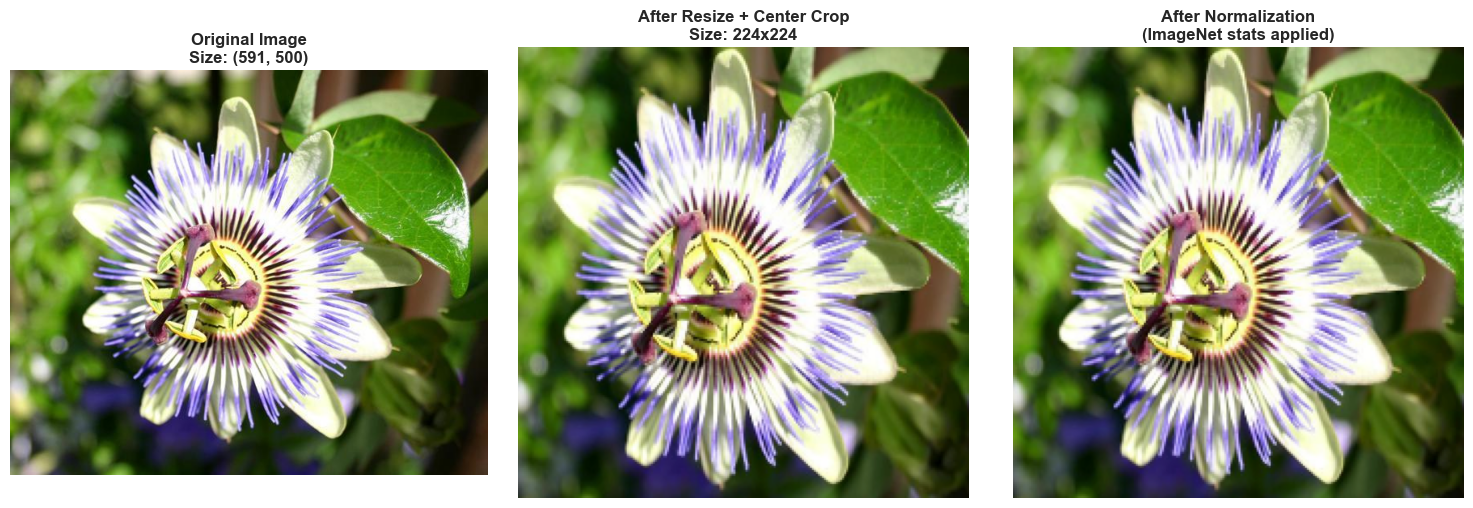

✓ Preprocessing visualization saved to D:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\plant-species-classification\results\figures\preprocessing_pipeline.png


In [15]:
# Apply validation transform (minimal preprocessing)
val_transformed = val_transform_wrapper(sample_image.copy())

# Convert to numpy for visualization
val_image_viz = tensor_to_image(val_transformed)

# Visualize preprocessing pipeline
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(sample_image)
axes[0].set_title(f'Original Image\nSize: {sample_image.size}', fontsize=12, fontweight='bold')
axes[0].axis('off')

# After resize and center crop
axes[1].imshow(val_image_viz)
axes[1].set_title(f'After Resize + Center Crop\nSize: {IMAGE_SIZE}x{IMAGE_SIZE}', 
                  fontsize=12, fontweight='bold')
axes[1].axis('off')

# Show normalization effect (denormalized for visualization)
axes[2].imshow(val_image_viz)
axes[2].set_title('After Normalization\n(ImageNet stats applied)', 
                  fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
save_path = OUTPUT_DIR / 'preprocessing_pipeline.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Preprocessing visualization saved to {save_path}")


## 6. Visualize Augmentation Effects

Apply training augmentation multiple times to the same image to demonstrate the variety of augmentations.


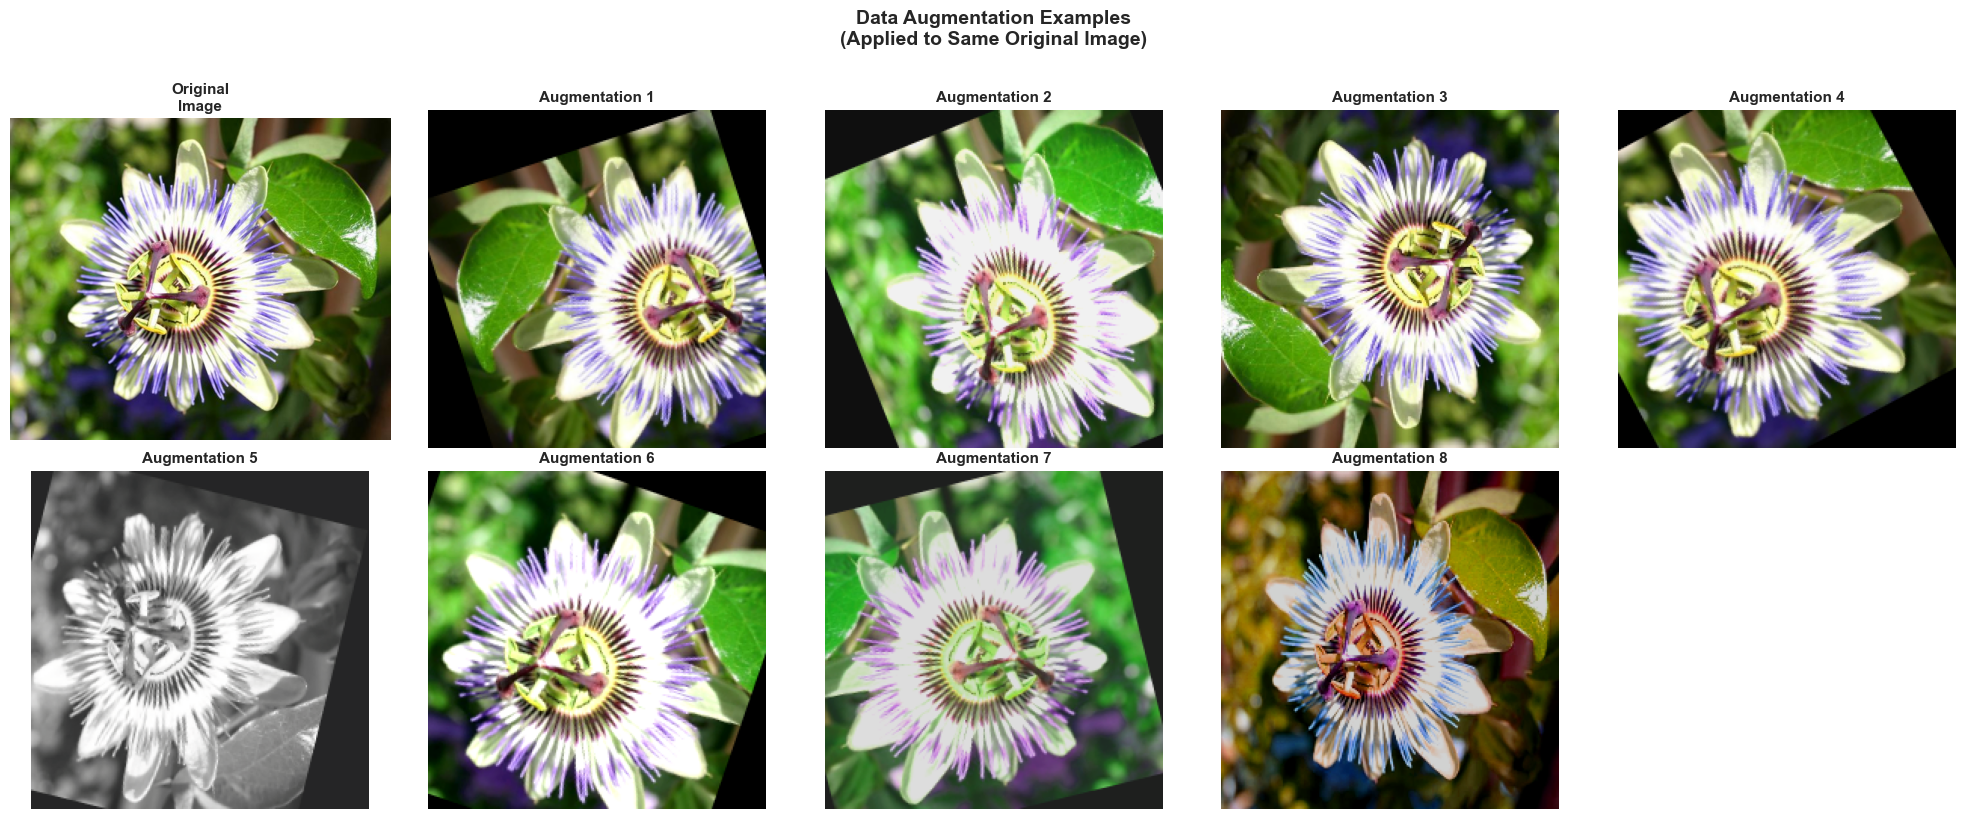

✓ Augmentation visualization saved to D:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\plant-species-classification\results\figures\augmentation_examples.png


In [16]:
# Apply training augmentation multiple times to show variety
n_augmentations = 8
augmented_images = []

for i in range(n_augmentations):
    aug_img = train_transform_wrapper(sample_image.copy())
    aug_img_viz = tensor_to_image(aug_img)
    augmented_images.append(aug_img_viz)

# Visualize original and augmented images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Show original in first position
axes[0, 0].imshow(sample_image)
axes[0, 0].set_title('Original\nImage', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

# Show augmented versions
for i in range(4):
    axes[0, i+1].imshow(augmented_images[i])
    axes[0, i+1].set_title(f'Augmentation {i+1}', fontsize=11, fontweight='bold')
    axes[0, i+1].axis('off')

for i in range(4, n_augmentations):
    axes[1, i-4].imshow(augmented_images[i])
    axes[1, i-4].set_title(f'Augmentation {i+1}', fontsize=11, fontweight='bold')
    axes[1, i-4].axis('off')

# Hide unused subplot
axes[1, 4].axis('off')

plt.suptitle('Data Augmentation Examples\n(Applied to Same Original Image)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
save_path = OUTPUT_DIR / 'augmentation_examples.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Augmentation visualization saved to {save_path}")


## 7. Create DataLoaders

Create PyTorch DataLoaders for training, validation, and test sets. This matches the exact pipeline used during model training.


In [17]:
if DATA_DIR is not None:
    # Create datasets
    train_dataset = FlowerDataset(
        root_dir=str(DATA_DIR),
        split='train',
        transform=train_transform_wrapper
    )
    
    val_dataset = FlowerDataset(
        root_dir=str(DATA_DIR),
        split='val',
        transform=val_transform_wrapper
    )
    
    test_dataset = FlowerDataset(
        root_dir=str(DATA_DIR),
        split='test',
        transform=val_transform_wrapper
    )
    
    print("✓ Datasets created successfully")
    print(f"\nDataset sizes:")
    print(f"  Training:   {len(train_dataset):,} samples")
    print(f"  Validation: {len(val_dataset):,} samples")
    print(f"  Test:       {len(test_dataset):,} samples")
    print(f"  Total:      {len(train_dataset) + len(val_dataset) + len(test_dataset):,} samples")
else:
    print("⚠ Data directory not found. Skipping DataLoader creation.")
    train_dataset = val_dataset = test_dataset = None


✓ Datasets created successfully

Dataset sizes:
  Training:   5,732 samples
  Validation: 1,228 samples
  Test:       1,229 samples
  Total:      8,189 samples


In [18]:
if train_dataset is not None:
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print("✓ DataLoaders created successfully")
    print(f"\nDataLoader configuration:")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Num workers: {NUM_WORKERS}")
    print(f"  Pin memory: {torch.cuda.is_available()}")
    print(f"\nBatches per epoch:")
    print(f"  Training:   {len(train_loader)} batches")
    print(f"  Validation: {len(val_loader)} batches")
    print(f"  Test:       {len(test_loader)} batches")


✓ DataLoaders created successfully

DataLoader configuration:
  Batch size: 32
  Num workers: 4
  Pin memory: True

Batches per epoch:
  Training:   180 batches
  Validation: 39 batches
  Test:       39 batches


## 8. Verify Data Loading Pipeline

Test the DataLoader by loading a batch and visualizing sample images.


✓ Batch loaded successfully
  Batch shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])
  Image dtype: torch.float32
  Label dtype: torch.uint8
  Image value range: [-2.1179, 2.6400]
  Sample labels: [93, 38, 56, 88, 5, 37, 28, 73]


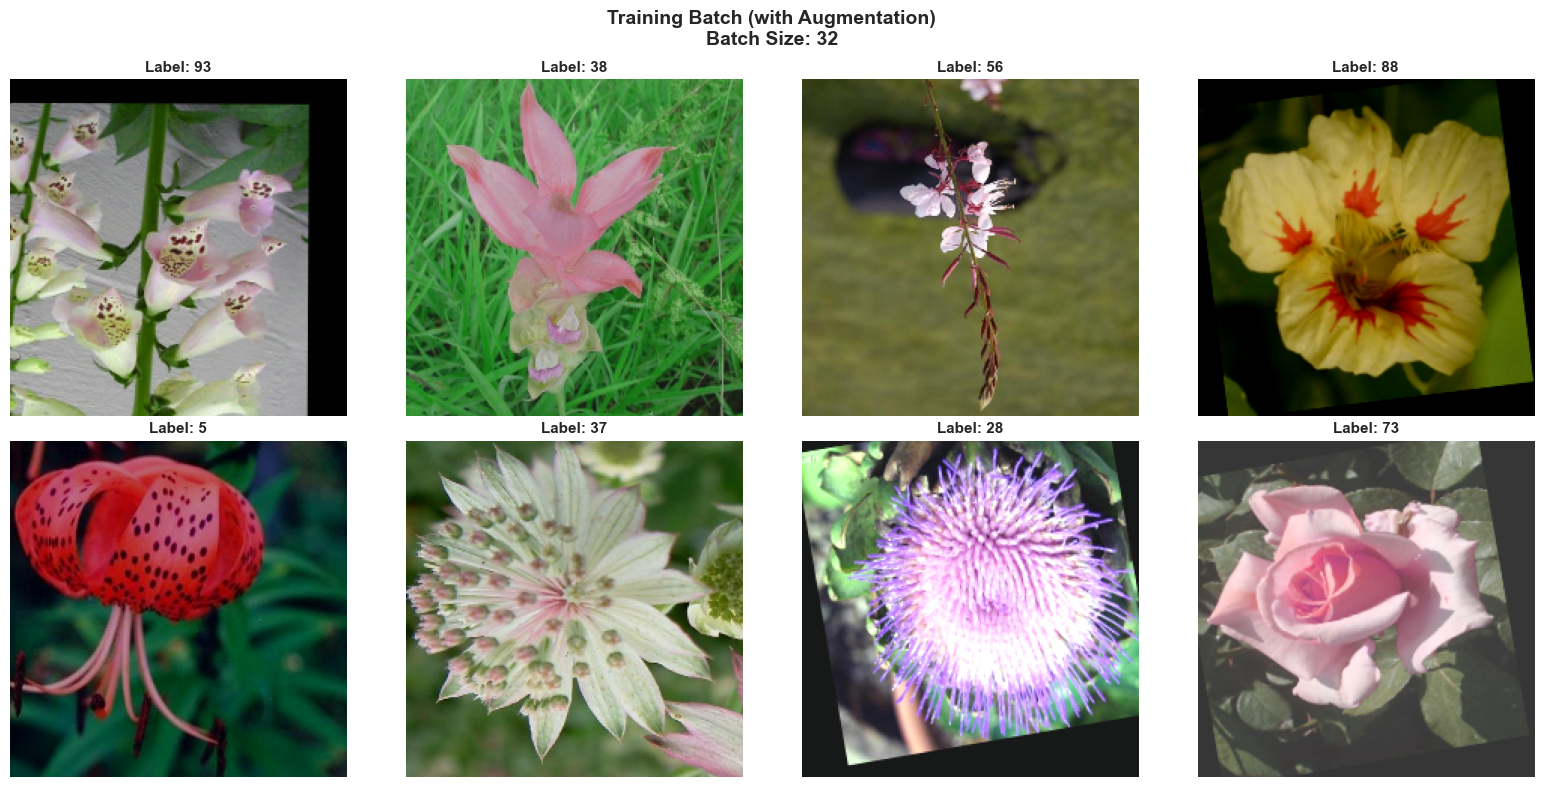


✓ Training batch visualization saved to D:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\plant-species-classification\results\figures\training_batch_sample.png


In [19]:
if train_loader is not None:
    # Get a batch from training loader
    train_iter = iter(train_loader)
    images, labels = next(train_iter)
    
    print(f"✓ Batch loaded successfully")
    print(f"  Batch shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Image dtype: {images.dtype}")
    print(f"  Label dtype: {labels.dtype}")
    print(f"  Image value range: [{images.min():.4f}, {images.max():.4f}]")
    print(f"  Sample labels: {labels[:8].tolist()}")
    
    # Visualize a batch of augmented images
    n_samples = min(8, BATCH_SIZE)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(n_samples):
        # Denormalize and convert to image
        img_viz = tensor_to_image(images[i])
        axes[i].imshow(img_viz)
        axes[i].set_title(f'Label: {labels[i].item()}', fontsize=11, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle(f'Training Batch (with Augmentation)\nBatch Size: {BATCH_SIZE}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    save_path = OUTPUT_DIR / 'training_batch_sample.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Training batch visualization saved to {save_path}")


✓ Validation batch loaded successfully
  Batch shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])


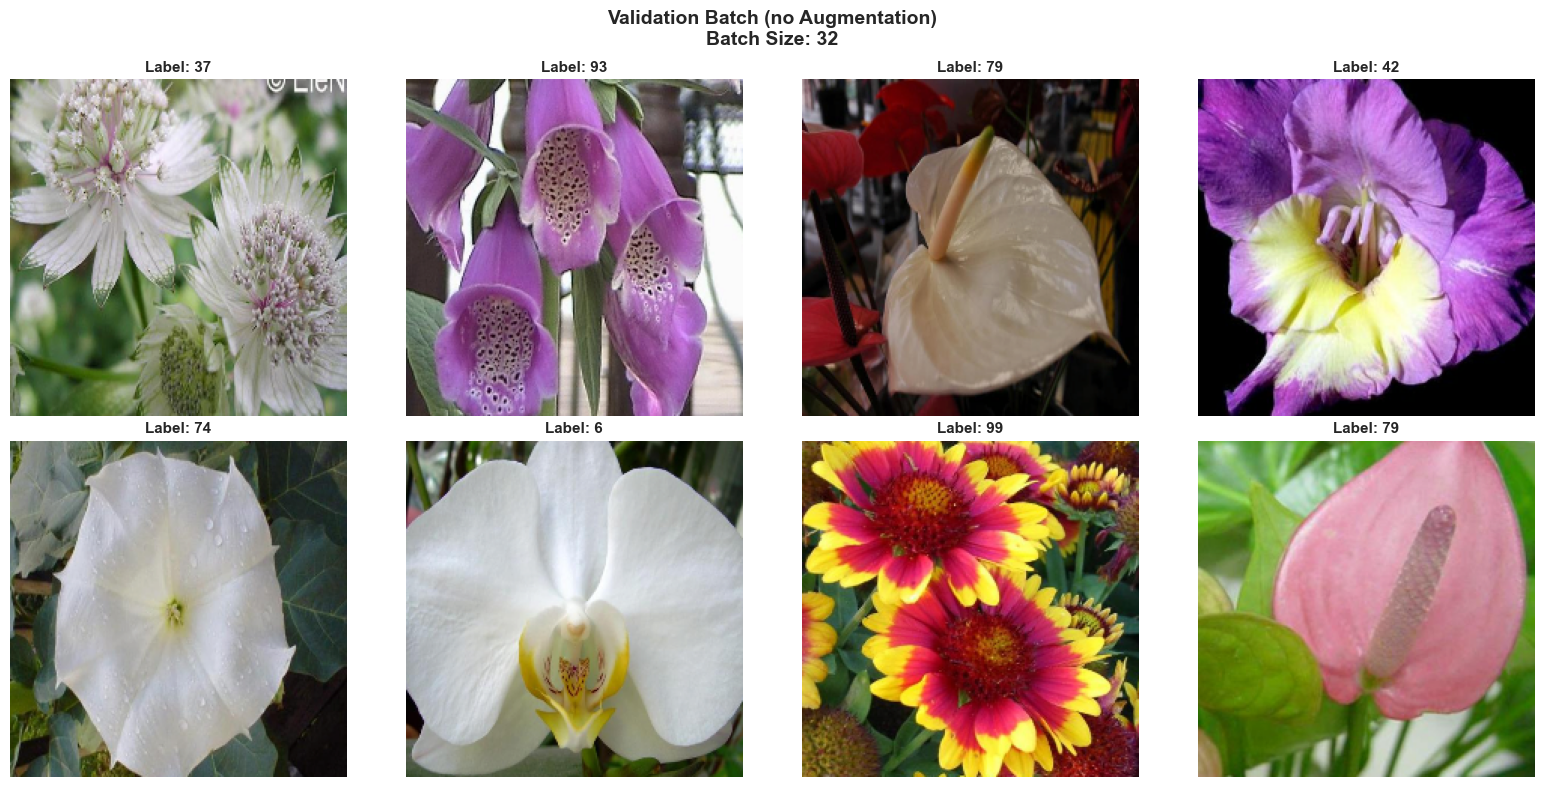


✓ Validation batch visualization saved to D:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\plant-species-classification\results\figures\validation_batch_sample.png


In [20]:
if val_loader is not None:
    # Get a batch from validation loader (no augmentation)
    val_iter = iter(val_loader)
    val_images, val_labels = next(val_iter)
    
    print(f"✓ Validation batch loaded successfully")
    print(f"  Batch shape: {val_images.shape}")
    print(f"  Labels shape: {val_labels.shape}")
    
    # Visualize validation batch
    n_samples = min(8, BATCH_SIZE)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(n_samples):
        img_viz = tensor_to_image(val_images[i])
        axes[i].imshow(img_viz)
        axes[i].set_title(f'Label: {val_labels[i].item()}', fontsize=11, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle(f'Validation Batch (no Augmentation)\nBatch Size: {BATCH_SIZE}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    save_path = OUTPUT_DIR / 'validation_batch_sample.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Validation batch visualization saved to {save_path}")


## 9. Preprocessing Pipeline Summary

### Training Transforms (with Augmentation)
1. **Random Resized Crop**: Randomly crops and resizes to 224×224
2. **Affine Transformations**: Translation, scaling, rotation
3. **Horizontal Flip**: 50% probability
4. **Vertical Flip**: 30% probability
5. **Color Jittering**: Brightness, contrast, saturation, hue variations
6. **Random Brightness/Contrast**: Additional 20% variation
7. **Grayscale Conversion**: 10% probability
8. **Gaussian Blur**: 10% probability
9. **Normalization**: ImageNet statistics (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
10. **ToTensor**: Convert to PyTorch tensor

### Validation/Test Transforms (no Augmentation)
1. **Resize**: Resize to 256×256 (for center crop margin)
2. **Center Crop**: Crop to 224×224
3. **Normalization**: ImageNet statistics
4. **ToTensor**: Convert to PyTorch tensor

### Data Splits
- **Training**: 70% of data (stratified split)
- **Validation**: 15% of data (stratified split)
- **Test**: 15% of data (stratified split)

### DataLoader Configuration
- **Batch Size**: 32
- **Num Workers**: 4
- **Shuffle**: True for training, False for validation/test
- **Pin Memory**: Enabled if CUDA available

This preprocessing pipeline was used for training both the Baseline CNN and ResNet50 models.


In [21]:
# Print summary
print("=" * 70)
print("PREPROCESSING PIPELINE SUMMARY")
print("=" * 70)
print(f"\nImage Configuration:")
print(f"  Target Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Normalization: ImageNet statistics")
print(f"    Mean: {IMAGENET_MEAN}")
print(f"    Std:  {IMAGENET_STD}")

print(f"\nTraining Augmentation:")
print(f"  ✓ Random Resized Crop (scale: 0.7-1.0, ratio: 0.8-1.2)")
print(f"  ✓ Affine Transformations (translation: ±10%, scale: ±10%, rotation: ±30°)")
print(f"  ✓ Horizontal Flip (50% probability)")
print(f"  ✓ Vertical Flip (30% probability)")
print(f"  ✓ Color Jittering (brightness/contrast/saturation: ±30%, hue: ±10%)")
print(f"  ✓ Random Brightness/Contrast (20% variation)")
print(f"  ✓ Grayscale Conversion (10% probability)")
print(f"  ✓ Gaussian Blur (10% probability)")

print(f"\nValidation/Test Preprocessing:")
print(f"  ✓ Resize to {IMAGE_SIZE + 32}x{IMAGE_SIZE + 32}")
print(f"  ✓ Center Crop to {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  ✓ Normalization")
print(f"  ✓ No augmentation")

if train_dataset is not None:
    print(f"\nDataset Statistics:")
    print(f"  Training samples:   {len(train_dataset):,}")
    print(f"  Validation samples: {len(val_dataset):,}")
    print(f"  Test samples:       {len(test_dataset):,}")
    print(f"  Total samples:      {len(train_dataset) + len(val_dataset) + len(test_dataset):,}")

print(f"\nDataLoader Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Num Workers: {NUM_WORKERS}")
if train_loader is not None:
    print(f"  Training batches per epoch: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    print(f"  Test batches: {len(test_loader)}")

print("\n" + "=" * 70)
print("✓ Preprocessing pipeline documentation complete!")
print("=" * 70)


PREPROCESSING PIPELINE SUMMARY

Image Configuration:
  Target Size: 224x224
  Normalization: ImageNet statistics
    Mean: [0.485, 0.456, 0.406]
    Std:  [0.229, 0.224, 0.225]

Training Augmentation:
  ✓ Random Resized Crop (scale: 0.7-1.0, ratio: 0.8-1.2)
  ✓ Affine Transformations (translation: ±10%, scale: ±10%, rotation: ±30°)
  ✓ Horizontal Flip (50% probability)
  ✓ Vertical Flip (30% probability)
  ✓ Color Jittering (brightness/contrast/saturation: ±30%, hue: ±10%)
  ✓ Random Brightness/Contrast (20% variation)
  ✓ Grayscale Conversion (10% probability)
  ✓ Gaussian Blur (10% probability)

Validation/Test Preprocessing:
  ✓ Resize to 256x256
  ✓ Center Crop to 224x224
  ✓ Normalization
  ✓ No augmentation

Dataset Statistics:
  Training samples:   5,732
  Validation samples: 1,228
  Test samples:       1,229
  Total samples:      8,189

DataLoader Configuration:
  Batch Size: 32
  Num Workers: 4
  Training batches per epoch: 180
  Validation batches: 39
  Test batches: 39

✓ Pr